<span style="display:block;text-align:center;margin-right:105px"></span>

# Blockchain based ROSCA - version 1
---

* [System Requirements (Part 1)](#System-Requirements)
  * [Model Introduction](#Model-Introduction)
  * [cadCad Overview](#cadCad-Overview)
  * [Requirements Analysis](#Requirements-Analysis)
  * [Visual System Mapping: Entity Relationship Diagram](#Visual-System-Mapping:-Entity-Relationship-Diagram)
  * [Visual System Mapping: Stock & Flow Diagram](#Visual-System-Mapping:-Stock-&-Flow-Diagram)
  * [Mathematical Specification](#Mathematical-Specification)
* [System Design (Part 2)](#System-Design)
  * [Differential Specification](#Differential-Specification)
  * [cadCAD Standard Notebook Layout](#cadCAD-Standard-Notebook-Layout)
    0. [Dependencies](#0.-Dependencies)
    1. [State Variables](#1.-State-Variables)
    2. [System Parameters](#2.-System-Parameters)
    3. [Policy Functions](#3.-Policy-Functions)
    4. [State Update Functions](#4.-State-Update-Functions)
    5. [Partial State Update Blocks](#5.-Partial-State-Update-Blocks)
    6. [Configuration](#6.-Configuration)
    7. [Execution](#7.-Execution)
    8. [Simulation Output Preparation](#8.-Simulation-Output-Preparation)
    9. [Simulation Analysis](#9.-Simulation-Analysis)
* [System Validation (Part 3)](#System-Validation)
    * [Model Limitations](#Model-Limitations)
    * [Model Improvements](#Model-Improvements)
---

# System Requirements

## Model Introduction
> ROSCAs are informal saving and credit institutions, whereby members pool together regular savings with are then dispersed to a member, either by random or based on the greatest need. This continues until every member has received the pot. 

ROSCAs are traditionally operated in small group within communities. I have found ROSCAs stand to be improved using blockchain technology - my review has demonstrated that blockchain technology certainly has the potential to create a more democratic, transparent truly peer-to-peer system. This has been proven by groups such as <a href="https://tlc.wetrust.io/">WeTRUST</a> who are attempting to: `"Create a blockchain-based Lending Circle dApp promoting financial inclusion and lay the groundwork for new financial tools for unbanked and underserved people throughout the world."` 

Having explored the profound social and economic implications of decentralized ledger technologies on ROSCAs, there is an implied pressing need for sustainable system design, which brings us to cadCad (complex adaptive dynamics Computer-aided design) which helps in designing, optimising, validating and understanding trivially non-complex, dynamical systems.

## cadCad Overview
cadCAD: Python library, assisting in the process of designing, testing and validating complex/economic systems through simulation. Allows you to ask powerful 'what-if' questions about your system, using simulation features such as A/B tests, parameter sweeps and Monte-Carlo analysis. 

These 'what-if' questions can concern system internal factors (eg. agent behaviours, system parameters) or system external factors (eg. market conditions, competitive activity). cadCad can model systems with various levels of abstractions from micro-level agent modelling to macro-level system dynamics.


## Requirements Analysis
Our goal for version 1 is to get an initial ROSCA circle running in a cadCad simulation environment. 
In this notebook, we want to: 
1. Present the dynamics of a single 'trusted' ROSCA circle on a peer-to-peer decentralised network where agents share a common view of the chain 
2. Define simple strategies for agents to: intiate intial ROSCA circle, be set a contribution amount set by initiator, be allocated the pot in a random order
3. Understand the basic space of decision making of players in the protocol

With this information, hopefully having demonstrated we can, in fact, reach our goal of `a fair, democratic, decentralised model solution of ROSCA`, we can build off of this version to implement:
1. Neccessary mechanisms eg: voting, borrowing 
2. Design incentives
3. Implement two types of circles (trusted & non-trusted)
4. Understand how agent behaviours map to the incentives (rewards, penaties, general outcomes)
5. Produce rich agent-based models

### Questions
1. What sort of mechanisms/incentives would we need to ensure agents participate in a way that fufils the systems goals
2. What are the penalties to deincentivise dishonest behaviour
3. What information is available to agents when their decisions are made


## Visual System Mapping: Entity Relationship Diagram

<!-- ![Entity Relationship diagram](images/entity.png) -->
<img src="images/entity.png">

At its simplest, the system allows for two core actions: `a participant contributing to the pool`, and `a participant receiving from the pool`. This takes into account a participants standing within the circle.

## Visual System Mapping: Stock & Flow Diagram

![Stock & Flow Diagram](./images/stockflow.png)

Represents and encodes the mathematical structure of a model. We identify a single stock, money pool, which gets its input from the source c, contributions from members and has a sink a, allocating to a participant in a given month.

## Mathematical Specification

![Math Spec](./images/spec.png)

The above differential equation gives a more formal mathematical representation of the 'money pool' physical quantity. The money in the pool at a given timestep, t is equal to the amount in the previous timestep, add c, the total sum of monthly agent contribution amount, minus a, the the amount allocated to agent (their monthly contribution * duration) 

---

# System Design

## Differential Specification

![Differential Spec](./images/diff.png)

In the cadCAD simulation methodology, we operate on four layers: Policies, Mechanisms, States, and Metrics. 
* Policies determine the inputs into the system dynamics, and can come from user input, observations from the exogenous environment, or algorithms. 
* Mechanisms are functions that take the policy decisions and update the States to reflect the policy level changes.
* States are variables that represent the system quantities at the given point in time 
* Metrics are computed from state variables to assess the health of the system. Metrics can often be thought of as KPIs, or Key Performance Indicators.

## cadCAD Standard Notebook Layout
<center>
<img src="./images/cadcad-flow.png"
     alt="cadCAD flow"
     style="width: 25%;" />
</center>

# 0. Dependencies

In [24]:
# Standard libraries: https://docs.python.org/3/library/
import math
import secrets
import random

# Analysis and plotting modules
import pandas as pd
import numpy as np

# Logic
import base_blockchain
from agents import (AgentData, update_contribution_amount, verify_allocated_amount, get_monthly_default_count)
from circle import (initialise_circle_state, update_circle_state, get_total_active_balance, get_total_montly_contribution)
from chain import(create_block)
from utils import (pounds_to_eth, eth_to_pounds)

In [25]:
# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

blockchain = base_blockchain.BlockChain()

# 1. State Variables

> A state variable is one of the set of variables that are used to describe the mathematical "state" of a dynamical system. ([Wikipedia](https://en.wikipedia.org/wiki/State_variable))

### Genesis state and genesis block
Dynamical systems are usually rather compact to define. We need at the very least two things:
1. Some initial state.
2. The dynamics, or how state evolves over time.

In this part we'll focus on the intial state. 
We'll create a genesis state, with 10 participants who each are set to pay 0.21 ETH (£300) into the money pool for a set term of 10 months, using a randomised turn system.

In [26]:
# Create an array of `AgentData` objects
def get_initial_deposits(n):
    agent = [AgentData(secrets.token_bytes(48), pounds_to_eth(300), i, 0, False, 0, False)
             for i in range(n)]
    return agent

In [27]:
# intialise a rosca circle 
circle_ = initialise_circle_state("Hudas saving circle :)", get_initial_deposits(10))

New ROSCA circle created - Hudas saving circle :)


In [28]:
# create initial block for the groups blockchain
genesis_state = create_block(circle_)

Added block: 12, hash - 5e640a9d57f7b51ffd55cc7028338d4cddf93ff51187deefbc1db7b5507a9fd0, prev_hash - 67b6e994d2336a9fd227a603415e1c127df6c565b753e601d2411d1503f02df0, timestep - 0



![Code Layout](images/layout.png)
Now we have created our rosca circle, and have processed a genesis block, with the code workflow above for clarity. Finally, we set the genesis state as the initial condition to our cadCAD execution

In [6]:
initial_conditions = {
    'pool_state': genesis_state
}

## **Time** as a system state
* 1 **timestep** == 1 month

# 2. System Parameters
> System parameterization is the process of choosing variables that impact the behaviour of the model. These parameters allow us to perform simulation techniques like parameter sweeps, Monte Carlo simulations, A/B tests, and see how the system behaves under a different model parameter set.

In [7]:
system_params = {
    'duration': [10], # duration of rosca circle
}
system_params

{'duration': [10]}

# 3. Policy Functions

> A Policy Function computes one or more signals to be passed to State Update Functions. They describe the logic  and behaviour of a system component  or mechanism.

#### In our differential specification, we identified two policies: 
1. A system decision - a monthly collection from agents 
2. A player decision - the decision to contribute the amount set out
Given a player decision we can distinguish between the default honest agent who pays their monthly contribution, and a randomised dishonest agent who doesn't contribute their monthly amount

In [29]:
# player decision
def randomised_agent_contribution(agent, amount):
    if random.random() < 0.1: # 10% chance player will default
        agent.defaulted = True
        print("Agent defaulted. Amount: " + str(amount))
        return False
    else :
        agent.defaulted = False
        return True

We now define the policy function, again using the arguments that the cadCAD environment gives us. In this simulation, we'll assume that there is a 10% chance of an agent defaulting.

In [30]:
# system policy - initate monthly contributions
def p_intitiate_monthly_deposits(params, substep, state_history, previous_state):
    month_sum = 0.0
    pool = previous_state['pool_state']
    block_agent_data = pool.data[0]['data']
    
    print("\n" + "STARTING ROSCA MONTH " + str(pool.data[0]['timestep']))
    
    # for each agent add their monthly contribution to the collected pool
    for x in range(0, len(block_agent_data)):
        agent_contribution = eth_to_pounds(block_agent_data[x].amount)

        # player decision
        if(randomised_agent_contribution(block_agent_data[x], agent_contribution) == True):
            month_sum += agent_contribution # c - from differential eq
            block_agent_data[x].contributed_amt += agent_contribution # update agent contributed amount
    print("Total deposited amount: GBP" + str(month_sum))
    return {'collected_amount': month_sum}   # todo: validate sum at later stage

# 4. State Update Functions
> We create State Update Functions to design the way our model state changes over time. These will usually represent the system differential specification.

```python
def state_update_function(params, substep, state_history, previous_state, policy_input):
    variable_value = 0
    return 'variable_name', variable_value
```

* `params` is a Python dictionary containing the **system parameters** <!-- for consistency with the previous definition -->
* `substep` is an integer value representing a step within a single `timestep`
* `state_history` is a Python list of all previous states
* `previous_state` is a Python dictionary that defines what the state of the system was at the **previous timestep** or **substep**
* `policy_input` is a Python dictionary of signals or actions from **policy functions**

### State evolution with block proposals
We can now move on to defining the dynamics. Simple dynamical systems follow some rules to update their state, e.g., the orbits of planets are given by laws derived from attraction. More complex systems are controlled: decisions made by agents in the system influence the state evolution.

In our setting, these agents are ROSCA participants. State evolution is governed by the rules set out by the system, while participants get to decide on putting in a transaction or defaulting. The resulting state is a combination of agent decisions and state updates. How participants make these decisions is embodied by policy functions: given a state, make a decision.

At the start of the process, the `genesis_state` defined above is `M(t-1)`, to update the state of the moneypool to `M(t)` we need to calculate `c - the amount collected from agents` and `α - the amount which is allocated`. Having defined the system policy for intiating monthly collections, we break the following actions into 2 steps:

#### 1. Allocate pool to agent according to standing within the circle 

In [31]:
# Allocate to agent according to standing
def allocate_pool(genesis_state, timestep, duration, p_collected_amt):
    block_agent_data = genesis_state.data[0]['data']
    pool_amount = p_collected_amt

    for x in range(0, len(block_agent_data)):
        if(block_agent_data[x].standing == timestep and block_agent_data[x].taken == False):
            allocation_amt = eth_to_pounds(duration*block_agent_data[x].amount) # a - from differential eq

            ## calculate allocating amount from policy
            if(verify_allocated_amount(block_agent_data[x], allocation_amt, pool_amount) == True):
                print("allocation_amt " + str(allocation_amt) + ", pool_amount" + str(pool_amount))
                block_agent_data[x].taken = True
                pool_amount -= allocation_amt
            else :
                print("Not enough money in pool to allocate agent full amount of: " + str(allocation_amt) + "\n")    
                allocation_amt = pool_amount
                block_agent_data[x].taken = False
                pool_amount = 0
                
            print("Allocating agent: " + str(block_agent_data[x].pubkey) + ", standing: " + str(block_agent_data[x].standing) + ", amount: GBP" + str(allocation_amt))
            block_agent_data[x].balance += allocation_amt
    return pool_amount

#### 2. Update state of circle and proccess and add block

In [32]:
def new_pool_state(genesis_state, timestep, duration, p_collected_amt):    
    
    new_pool_amount = allocate_pool(genesis_state, timestep, duration, p_collected_amt)    
    updateCircle_ = update_circle_state(genesis_state.data[0]['name'], timestep+1, p_collected_amt, new_pool_amount, genesis_state.data[0]['data'])
    new_block = create_block(updateCircle_) # create block
    print("Pool amount: GBP" + str(get_total_active_balance(updateCircle_)))
    print("ENDING PROCESS")
        
    return new_block

In [33]:
# Relevant state variables
current_pool_state = initial_conditions['pool_state']

# Relevant parameters
duration = system_params['duration'][0] #  from "alpha" in our differential equation

In [34]:
def s_updatepool(params, substep, state_history, previous_state, policy_input):
    """
    Update the pool state according to the differential equation (1):
    current_pool_state + collected_amount - allocation_amount
    """
    pool = previous_state['pool_state']
    duration = params['duration']
    calc_timestep = pool.data[0]['timestep'] 
    p_collected_amt = policy_input['collected_amount']
    
    return 'pool_state', new_pool_state(pool, calc_timestep, duration, p_collected_amt)

# 5. Partial State Update Blocks
> A series of Partial State Update Blocks is a structure for composing State Update Functions and Policy Functions in series or parallel, as a representation of the system model. 

<center>
<img src="./images/basic-psub.png"
     alt="Policy functions"
     style="width: 60%;" />
</center>

In [35]:
partial_state_update_blocks = [
    {
        'policies': {
            'collected_amount': p_intitiate_monthly_deposits,
        }, 
        # State variables
        'variables': {
            # Updated in parallel
            'pool_state': s_updatepool,
        }
    }
]

# 6. Configuration
> The configuration stage is about tying all the previous model components together and choosing how the simulation should run.

![Flow](./images/cadflow2.png)

Configuration parameters:
* `'N': 1` - the number of times we'll run the simulation (called "Monte Carlo runs" later)
* `'T': range(10)` - the number of timesteps the simulation will run for
* `'M': system_params` - the parameters of the system

In [36]:
sim_config = config_sim({
    "N": 1,
    "T": range(10),
    "M": system_params
})

In [37]:
from cadCAD import configs
del configs[:] # Clear any prior configs

In [38]:
experiment = Experiment()
experiment.append_configs(
    initial_state = initial_conditions,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)
configs[-1].__dict__

{'sim_config': {'N': 1,
  'T': range(0, 10),
  'M': {'duration': 10},
  'subset_id': 0,
  'subset_window': deque([0, None]),
  'simulation_id': 0,
  'run_id': 0},
 'initial_state': {'pool_state': 1 - 88914 - ba235a378a42bcd66d5913a44e8cda271b29d429c94cf07abb6f06ea9bb1fd12 - [{'name': 'Hudas saving circle :)', 'timestep': 0, 'collected_amt': 0.0, 'balance': 0.0, 'data': [<agents.AgentData object at 0x10cda95b0>, <agents.AgentData object at 0x10cda9220>, <agents.AgentData object at 0x10cda9040>, <agents.AgentData object at 0x10cda9130>, <agents.AgentData object at 0x10cda90d0>, <agents.AgentData object at 0x10cda9100>, <agents.AgentData object at 0x10cda91f0>, <agents.AgentData object at 0x10cda9070>, <agents.AgentData object at 0x10cd5c2e0>, <agents.AgentData object at 0x10cd8c1f0>]}] - 1615811893.528544},
 'seeds': {},
 'env_processes': {},
 'exogenous_states': {},
 'partial_state_updates': [{'policies': {'collected_amount': <function __main__.p_intitiate_monthly_deposits(params, subst

# 7. Execution

> The Execution Engine takes a model and configuration, and computes the simulation output.

## Configuring the cadCAD simulation execution

In [39]:
exec_context = ExecutionContext()

In [40]:
simulation = Executor(exec_context=exec_context, configs=configs)

## We can now simulate our ROSCA model!

In [41]:
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded

STARTING ROSCA MONTH 0
Agent defaulted. Amount: 300.0
Agent defaulted. Amount: 300.0
Total deposited amount: GBP2400.0
Not enough money in pool to allocate agent full amount of: 3000.0

Allocating agent: b'\xd8=q\x80.OdM\x18\xd0\x9c/\xdc36Q\xc7\xc9\xdf\x05\xa9m\x010i\xaf\xb3St\x83\xb4O\x1cU\xf97\xce\xb4O\x9e\x14\xf98\xbc\xf5\xc3\xe7\xd7', standing: 0, amount: GBP2400.0
Updating circle state..
Added block: 13, hash - 9cda2da4fc93609b0e3531ecf7eea1d0f92a8abb2a7e295dee055395ee176f40, prev_hash - 5e640a9d57f7b51ffd55cc7028338d4cddf9

# 8. Simulation Output Preparation
> The simulation results are returned as a list of Python dictionaries, which we then convert to a Pandas dataframe. At this stage of the process we'll manipulate and analyze our results to answer questions about our model.

In [42]:
simulation_result = pd.DataFrame(raw_result)
df = simulation_result.copy()

total_amt = get_total_montly_contribution(genesis_state.data[0]['data'])

balance=[] 
collected=[]
missing=[]
defaulted=[]

for index, row in simulation_result.iterrows():
    balance.append(row.pool_state.data[0]['balance']),
    collected.append(row.pool_state.data[0]['collected_amt']),
    missing.append(total_amt - row.pool_state.data[0]['collected_amt']),
    defaulted.append(get_monthly_default_count(row.pool_state.data[0]['data']))
    
df['collected_amount'] = np.array(collected).tolist()
df['defaulted_amount'] = np.array(missing).tolist()
df['pool_balance'] = np.array(balance).tolist()
df['agent_default_count'] = np.array(defaulted).tolist()
df.iloc[:,5:11][1:11]

,timestep,collected_amount,defaulted_amount,pool_balance,agent_default_count
1,1,2400.0,600.0,0.0,2
2,2,2700.0,300.0,0.0,1
3,3,2700.0,300.0,0.0,1
4,4,3000.0,0.0,0.0,0
5,5,2400.0,600.0,0.0,2
6,6,2700.0,300.0,0.0,1
7,7,2700.0,300.0,0.0,1
8,8,2400.0,600.0,0.0,2
9,9,2400.0,600.0,0.0,2
10,10,2700.0,300.0,0.0,1


# 9. Simulation Analysis
  
From the above table, we see two things; randomness in the number of times and when an agent defaults and given we've set the amount given to the agents monthly as £3000, we see the number of times an agent recieves their full payout is low compared to the number of times they don't.

<AxesSubplot:xlabel='timestep'>

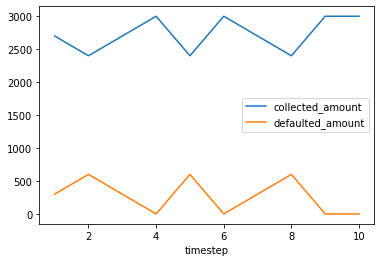

In [22]:
df[df.timestep >= 1].plot(kind='line', x='timestep', y=['collected_amount','defaulted_amount'])

<AxesSubplot:xlabel='timestep'>

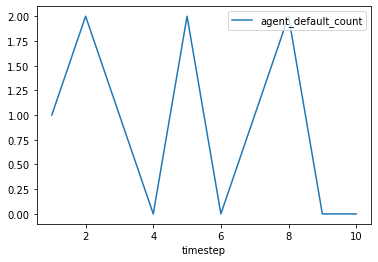

In [23]:
df[df.timestep >= 1].plot(kind='line', x='timestep', y=['agent_default_count'])

# System Validation

## Model Limitations
1. The chance of default is set to 10% for a given agent - realistically this number is affected by a number of factors for an example: the size of prize and standing, if you have been selected to take the pooled money first without contributing any money yet.
2. Agents in this system are not incentivised or dis-incentivised

## Model Improvements

[Requirements Analysis](#Requirements-Analysis)

Looking at the requirements we set out, we have created a simple ROSCA model which presents the dynamics of a ROSCA circle on a blockchain network where participants can carry out two core actions: contributing to the pool and receiving from the pool. 

[Questions](#Questions)

#### How can we extend this model to introduce additional complexity to more fit real world implementations?
  * We can define specific agent behaviour and test what happens under different scenarios. Here we have randomly set a 10% chance for an agent defaulting - this can be a more precise number considering a range of factors and possible actions
  * We can model the two types of rosca circle. Here we have modelled a 'trusted rosca circle' in which we don't assign an agent trust rating and according to this consider their 'standing' or turn to take the pot
  * Design incentives to ensure agents behave in a way that fulfils protocol
  * Design mechanisms outlined in Interim Report, eg: voting and borrowing, building of our core mechanisms defined here.